In [20]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score

##### Read Data

Dataset consists of AWS EC2 CPU utilization values.

- Columns: Timestamp, Value
- Number of Rows: 4032

Data Source: https://github.com/numenta/NAB/blob/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv

In [4]:
data = pd.read_csv('./data/ec2_cpu_utilization_24ae8d.csv')

#### Descriptive Statistics

- Calculate mean, median, max, min, and kurtosis values. 
- Plot CPU utilization distribution in the form of a density plot.

Mean CPU Utilization: 0.1263030753968254
Median CPU Utilization: 0.134
Maximum CPU Utilization: 2.344
Minimum CPU Utilization: 0.066
Number of values >=0.1 and/or <= -0.06 from Median CPU Utilization: 931 (23.09%)
Sample Excess Kurtosis: 229.92534587955123


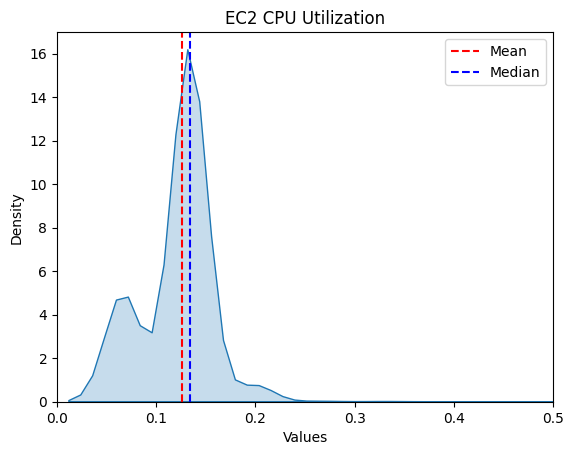

In [5]:
# Calculate the mean of the 'column_name' column
mean_value = data['value'].mean()
print("Mean CPU Utilization:", mean_value)
# Calculate the median of the 'column_name' column
median_value = data['value'].median()
print("Median CPU Utilization:", median_value)

# Calculate the maximum value in the 'column_name' column
max_value = data['value'].max()
print("Maximum CPU Utilization:", max_value)
# Calculate the minimum value in the 'column_name' column
min_value = data['value'].min()
print("Minimum CPU Utilization:", min_value)

# Check for skew
data['mean_value_diff'] = data['value'] - mean_value
data['median_value_diff'] = data['value'] - median_value
print("Number of values >=0.1 and/or <= -0.06 from Median CPU Utilization:", len(data[(data['median_value_diff'] >= 0.1) | (data['median_value_diff'] <= -0.06)]), f"({round((len(data[(data['median_value_diff'] >= 0.1) | (data['median_value_diff'] <= -0.06)])/len(data))*100, 2)}%)")

# Calculate the kurtosis of the data set
data_kurtosis = kurtosis(data['value'], fisher=True)
print("Sample Excess Kurtosis:", data_kurtosis)

# Generate a density plot
sns.kdeplot(data=data['value'], fill=True)
# Add vertical lines for mean and median
plt.xlim(0, 0.5)
plt.axvline(mean_value, color='red', linestyle='--', label='Mean')
plt.axvline(median_value, color='blue', linestyle='--', label='Median')
# Add labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('EC2 CPU Utilization')
# Show the legend with line labels
plt.legend()
# Show the plot
plt.show()


#### Unsupervised Anomaly Detection using Isolation Forest

In [6]:
#Isolate CPU Utilization values for anomaly detection
output = np.array([data['mean_value_diff']])
output = output.reshape(-1, 1)

In [7]:
# Perform anomaly detection using Isolation Forest
isolation_forest = IsolationForest(n_estimators=4032, contamination=0.05, random_state=42)
isolation_forest.fit(output)

# Predict anomalies
predictions = isolation_forest.predict(output)

In [8]:
# Recode anomalous prediction values
predictions = [1 if pred == -1 else 0 for pred in predictions]

# View Isolation Forest Predictions
data['predictions'] = predictions
print(data[data['predictions']== 1])

# Separate data based on the 'prediction' value
prediction_0 = data[data['predictions'] == 0]
prediction_1 = data[data['predictions'] == 1]

                timestamp  value  mean_value_diff  median_value_diff  \
13    2014-02-14 15:35:00  0.202         0.075697              0.068   
41    2014-02-14 17:55:00  0.202         0.075697              0.068   
61    2014-02-14 19:35:00  0.200         0.073697              0.066   
70    2014-02-14 20:20:00  0.200         0.073697              0.066   
113   2014-02-14 23:55:00  0.200         0.073697              0.066   
...                   ...    ...              ...                ...   
3875  2014-02-28 01:25:00  0.200         0.073697              0.066   
3898  2014-02-28 03:20:00  1.600         1.473697              1.466   
3969  2014-02-28 09:15:00  0.200         0.073697              0.066   
3977  2014-02-28 09:55:00  0.202         0.075697              0.068   
3997  2014-02-28 11:35:00  0.202         0.075697              0.068   

      predictions  
13              1  
41              1  
61              1  
70              1  
113             1  
...           .

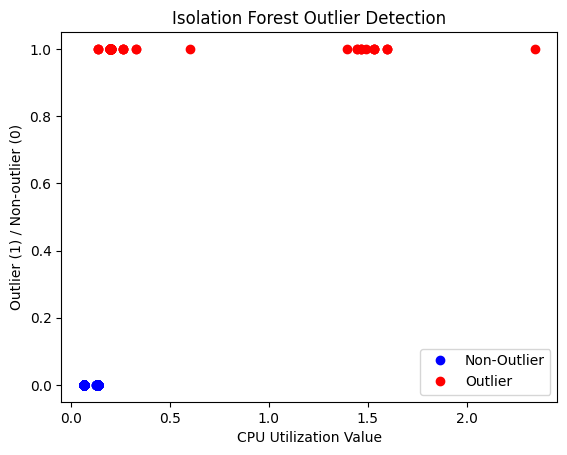

In [9]:
# Visualize prediction results
plt.plot(prediction_0['value'], prediction_0['predictions'], marker='o', linestyle='', color='blue', label='Non-Outlier')
plt.plot(prediction_1['value'], prediction_1['predictions'], marker='o', linestyle='', color='red', label='Outlier')
plt.xlabel('CPU Utilization Value')
plt.ylabel('Outlier (1) / Non-outlier (0)')
plt.title('Isolation Forest Outlier Detection')
plt.legend()
plt.show()

From prediction results we can see Isolation Forest model with a contamination rate of 0.05 performed well at detecting anomalous utilization values greater than the mean/median. 162 datapoints were predicted to be anomalous (~4% of 4032 data points). However, it is missing the second group of outliers (i.e., when utilization < 0.06). This limitation in model performance could be due to insufficient data. 

In [ ]:
normal_data = data[(data['mean_value_diff'] < 0.012)]# | (data['median_value_diff'] > -0.01)]
anomaly_data = data[(data['mean_value_diff'] >= 0.012)]# | (data['median_value_diff'] <= -0.01)]
normal_data['actual'] = 0
anomaly_data['actual'] =  1
df = pd.concat([normal_data, anomaly_data], ignore_index=True)

In [126]:
# Calculate the confusion matrix
cm = confusion_matrix(df['actual'], df['predictions'])

# Calculate Precision/Recall 
precision = precision_score(df['actual'], df['predictions'], zero_division=1)
recall = recall_score(df['actual'], df['predictions'], zero_division=1)

# Print the confusion matrix and AUC score
print("Confusion Matrix:")
print(cm)
print('Precision:', precision)
print('Recall:', recall)

Confusion Matrix:
[[3870    2]
 [   0  160]]
Precision: 0.9876543209876543
Recall: 1.0


In [118]:
# False-Positive Values 
normal_data[normal_data['predictions']==1]

,timestamp,value,mean_value_diff,median_value_diff,predictions,actual
1265,2014-02-18 23:55:00,0.138,0.011697,0.004,1,0
3857,2014-02-27 23:55:00,0.138,0.011697,0.004,1,0


In [120]:
# Range of anomalous values
print(sorted(set(anomaly_data['value'])))

[0.14, 0.196, 0.198, 0.2, 0.2019999999999999, 0.204, 0.264, 0.266, 0.3279999999999999, 0.332, 0.602, 1.398, 1.444, 1.466, 1.4680000000000002, 1.49, 1.5319999999999998, 1.534, 1.598, 1.6, 2.344]


In [121]:
# Range of nonanomalous values
print(sorted(set(normal_data['value'])))

[0.066, 0.068, 0.128, 0.13, 0.132, 0.134, 0.136, 0.138]


When we don't include the lower range of anomalous values (e.g., 0.066, 0.068) we see that precision and recall are both high. The model is correctly identifying outliers with respect to upper bounds of IQR. 

Now let's include the lower bounds, and evaluate model performance.

In [ ]:
normal_data = data[(data['mean_value_diff'] < 0.012) | (data['median_value_diff'] > -0.01)]
anomaly_data = data[(data['mean_value_diff'] >= 0.012) | (data['median_value_diff'] <= -0.01)]
normal_data['actual'] = 0
anomaly_data['actual'] =  1
df = pd.concat([normal_data, anomaly_data], ignore_index=True)

In [128]:
# Calculate the confusion matrix
cm = confusion_matrix(df['actual'], df['predictions'])

# Calculate Precision/Recall 
precision = precision_score(df['actual'], df['predictions'], zero_division=1)
recall = recall_score(df['actual'], df['predictions'], zero_division=1)

# Print the confusion matrix and AUC score
print("Confusion Matrix:")
print(cm)
print('Precision:', precision)
print('Recall:', recall)

Confusion Matrix:
[[3870  162]
 [ 909  160]]
Precision: 0.4968944099378882
Recall: 0.14967259120673526


When we include the lower range of anomalous values, precision drops to ~50% and recall to ~15%. Evaluating IQR below confirms classification of lower values as statistically anomalous.

First Quartile (Q1): 0.132
Third Quartile (Q3): 0.134
Interquartile Range (IQR): 0.0020000000000000018
Lower bounds: 0.129 Upper bounds: 0.137


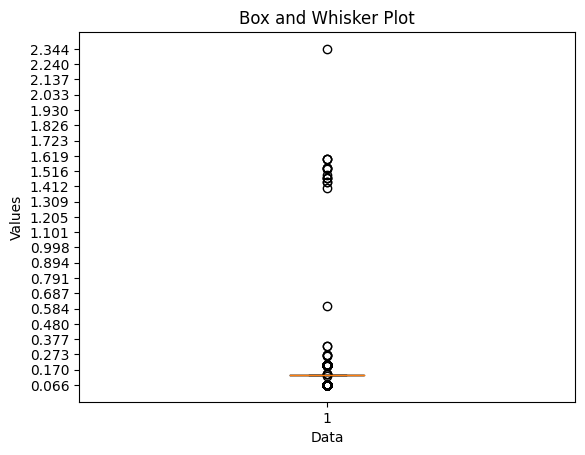

In [140]:
# Calculate the IQR
q1 = np.percentile(data['value'], 25)
q3 = np.percentile(data['value'], 75)
iqr = q3 - q1
outliers_q1 = q1 - 1.5 * iqr 
outliers_q3 = q3 + 1.5 * iqr

print("First Quartile (Q1):", q1)
print("Third Quartile (Q3):", q3)
print("Interquartile Range (IQR):", iqr)
print("Lower bounds:", outliers_q1, "Upper bounds:", outliers_q3)

# Create a box and whisker plot with custom ticks
data_range = max(data['value']) - min(data['value'])
num_ticks = int(data_range / 0.1) + 1
custom_ticks = np.linspace(min(data['value']), max(data['value']), num=num_ticks)

plt.boxplot(data['value'])

# Add labels and title
plt.xlabel("Data")
plt.ylabel("Values")
plt.title("Box and Whisker Plot")
plt.yticks(custom_ticks)
# Show the plot
plt.show()

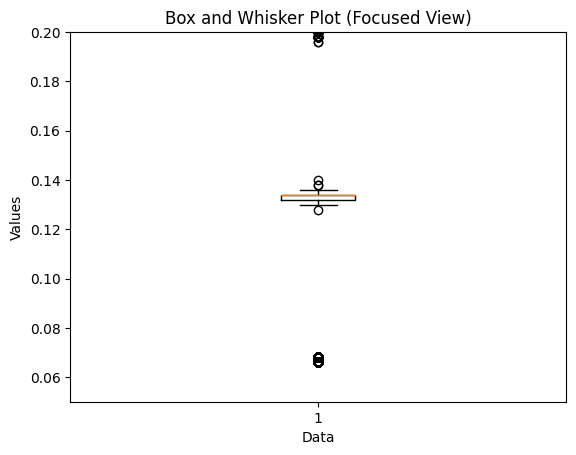

In [141]:
# Create a box and whisker plot
plt.boxplot(data['value'])
# Add labels and title
plt.xlabel("Data")
plt.ylabel("Values")
plt.title("Box and Whisker Plot (Focused View)")
# Add contraint on y-axis value range
plt.ylim(0.05, .2)
# Show the plot
plt.show()
